In [2]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPool2D, Flatten, Activation, BatchNormalization, Add, AveragePooling2D, Input, ZeroPadding2D, concatenate, GlobalAveragePooling2D, Lambda
from keras.initializers import glorot_uniform, Constant
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [3]:
def conv2d(X, num_filters, filter_size, strides=1, padding="same", activation="relu", name=None, kernel_initializer=None, bias_initializer=None):
    X = Conv2D(num_filters, filter_size, strides=strides, padding=padding, 
               kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, name=name)(X)
    X = BatchNormalization(axis=3, scale=False)(X)
    if activation:
        X = Activation(activation)(X)
    return X

In [4]:
def Stem(input_layer, kernel_init, bias_init, name=None):
    X = conv2d(input_layer, 32, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X = conv2d(X, 32, (3, 3), strides=1, padding="valid", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X = conv2d(X, 192, (3, 3), strides=1, padding="valid", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
#     X1 = MaxPool2D((3, 3), strides=(2, 2), padding="valid")(X)
    
#     X2 = conv2d(X, 96, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init,
#                bias_initializer=bias_init)
    
#     X = concatenate([X1, X2], axis=3)
    
#     X1 = conv2d(X, 64, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
#                bias_initializer=bias_init)

#     X1 = conv2d(X1, 96, (3, 3), strides=1, padding="valid", activation="relu", kernel_initializer=kernel_init,
#                bias_initializer=bias_init)

#     X2 = conv2d(X, 64, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
#                bias_initializer=bias_init)
    
#     X2 = conv2d(X2, 64, (7, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
#                bias_initializer=bias_init)

#     X2 = conv2d(X2, 64, (1, 7), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
#                bias_initializer=bias_init)

#     X2 = conv2d(X2, 96, (3, 3), strides=1, padding="valid", activation="relu", kernel_initializer=kernel_init,
#                bias_initializer=bias_init)
    
#     X = concatenate([X1, X2], axis=3)
    
#     X1 = conv2d(X, 192, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init,
#                bias_initializer=bias_init)
    
#     X2 = MaxPool2D((3, 3), strides=(2, 2), padding="valid")(X)
    
#     X = concatenate([X1, X2], axis=3, name=name)
    
    return X

In [5]:
def Normal1(X, X_prev, kernel_init=None, bias_init=None, name=None, scale=1):
    X_short = X
    
    
    X1 = conv2d(X, 64*scale, (1, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X2 = conv2d(X, 32*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X2 = conv2d(X2, 48*scale, (3, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X2 = conv2d(X2, 64*scale, (3, 3), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X_add_1 = Add()([X1, X2])
    X_add_1 = Activation("relu")(X_add_1)
    
    
    X3 = conv2d(X_prev, 64*scale, (1, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X4 = conv2d(X_prev, 32*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X4 = conv2d(X4, 48*scale, (3, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X4 = conv2d(X4, 64*scale, (3, 3), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X_add_2 = Add()([X3, X4])
    X_add_2 = Activation("relu")(X_add_2)
    
    X5 = conv2d(X, 32*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X5 = conv2d(X5, 64*scale, (3, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X_conc = concatenate([X_add_1, X_add_2, X5], axis=3)
    
    X_conc = conv2d(X_conc, 384*scale, (1, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X_fin = Add()([X_conc, X_short])
    X_fin = Activation("relu", name=name)(X_fin)
    
    return X_fin

In [6]:
def Reduction1(X, X_prev, kernel_init=None, bias_init=None, name=None, scale=1):
    X1 = conv2d(X, 128, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X1 = conv2d(X1, 128, (3, 3), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X2 = conv2d(X_prev, 128, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X2 = conv2d(X2, 128, (1, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X3 = conv2d(X_prev, 64, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X3 = conv2d(X3, 96, (1, 7), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X3 = conv2d(X3, 128, (7, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X4 = MaxPool2D((3, 3), strides=1, padding="same")(X)
    
    
    X5 = conv2d(X, 96, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X5 = conv2d(X5, 128, (1, 5), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X5 = conv2d(X5, 128, (5, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X6 = MaxPool2D((3, 3), strides=1, padding="same")(X_prev)
    X6 = conv2d(X6, 128, (1, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X7 = conv2d(X, 128, (3, 3), strides=2, padding="valid", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X_add_1 = Add()([X1, X2])
    X_add_1 = Activation("relu")(X_add_1)
    
    
    X8 = MaxPool2D((3, 3), strides=2, padding="valid")(X_add_1)
    
    X_add_1_2 = Add()([X8, X7])
    X_add_1_2 = Activation("relu")(X_add_1_2)
    
    
    X_conc_1 = concatenate([X3, X4], axis=3)
    
    
    X_add_2_1 = Add()([X6, X5])
    X_add_2_1 = Activation("relu")(X_add_2_1)
    
    
    X9 = conv2d(X_conc_1, 128, (3, 3), strides=2, padding="valid", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    X10 = conv2d(X_add_2_1, 128, (3, 3), strides=2, padding="valid", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X_add_2_2 = Add()([X9, X10])
    X_add_2_2 = Activation("relu")(X_add_2_2)
    
    
    X11 = MaxPool2D((3, 3), strides=2, padding="valid")(X_add_2_1)
    
    
    X_fin = concatenate([X_add_1_2, X_add_2_2, X11], axis=3, name=name)
    X_fin = conv2d(X_fin, 384*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    return X_fin

In [7]:
def Model1(size=(299, 299, 3), n_classes=5, name=None):
    input_layer = Input(shape=size)
    kernel_init = glorot_uniform()
    bias_init = None
    
    X0 = Stem(input_layer, kernel_init, bias_init, name="Stem")
    X_mem = X0
    X_mem = conv2d(X_mem, 32, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X_0_1 = conv2d(X0, 192, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init) 
    X_0_2 = MaxPool2D((3, 3), strides=(2, 2), padding="valid")(X0)
    X0 = concatenate([X_0_1, X_0_2], axis=3, name="stem")
    
    
    X1_1 = Normal1(X0, X_mem, name="Norm1_1")
    X1_2 = Normal1(X1_1, X0, name="Norm1_2")
#     X1_3 = Normal1(X1_2, X1_1, name="Norm1_3")
#     X1_4 = Normal1(X1_3, X1_2, name="Norm1_4")
#     X1_5 = Normal1(X1_4, X1_3, name="Norm1_5")
    
    
    X2 = Reduction1(X1_2, X1_1, name="Reduce1", scale=2)
    
    X_mem2 = X1_2
    X_mem2 = conv2d(X_mem2, 32, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X2_1 = Normal1(X2, X_mem2, name="Norm2_1", scale=2)
    X2_2 = Normal1(X2_1, X2, name="Norm2_2", scale=2)
#     X2_3 = Normal1(X2_2, X2_1, name="Norm2_3", scale=2)
#     X2_4 = Normal1(X2_3, X2_2, name="Norm2_4", scale=2)
#     X2_5 = Normal1(X2_4, X2_3, name="Norm2_5", scale=2)
#     X2_6 = Normal1(X2_5, X2_4, name="Norm2_6", scale=2)
#     X2_7 = Normal1(X2_6, X2_5, name="Norm2_7", scale=2)


    X3 = Reduction1(X2_2, X2_1, name="Reduce2", scale=3)
    
    X_mem3 = X2_2
    X_mem3 = conv2d(X_mem3, 32, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X3_1 = Normal1(X3, X_mem3, name="Norm3_1", scale=3)
    X3_2 = Normal1(X3_1, X3, name="Norm3_2", scale=3)
#     X3_3 = Normal1(X3_2, X3_1, name="Norm3_3", scale=3)


    X4 = Reduction1(X3_2, X3_1, name="Reduce3", scale=4)
    
    X_mem4 = X3_2
    X_mem4 = conv2d(X_mem4, 32, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)

    
    X4_1 = Normal1(X4, X_mem4, name="Norm4_1", scale=4)
    X4_2 = Normal1(X4_1, X4, name="Norm4_2", scale=4)
    
    
    X_fin = GlobalAveragePooling2D(name="GLBL_Pool")(X4_2)
    X_fin = Dropout(.8)(X_fin)
    X_fin = Dense(n_classes, activation="softmax", name="final_out")(X_fin)
    
    model = Model(input_layer, X_fin, name="V1.0")
    
    return model

In [8]:
nn = Model1()

In [9]:
nn.summary()

Model: "V1.0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

In [9]:
# plot_model(nn, to_file="test.png")

In [10]:
import math

In [39]:
# nn = Model1(size=(299, 299, 3), n_classes=5)
    
initial_lrate = .02
def decay(epoch, steps=100):
    init_rate = .02
    drop = .95
    epochs_drop = 4
    lrate = init_rate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

RMS = SGD(lr=initial_lrate)

In [40]:
mcp_save = ModelCheckpoint("Weights_epochs_BEST.h5", save_best_only=True, monitor='val_loss', mode='min')

In [41]:
nn.compile(loss=["categorical_crossentropy"], optimizer=RMS, metrics=["accuracy"])

In [14]:
params = [{'samplewise_center':1, 'samplewise_std_normalization':1}, {'featurewise_center':1, 'featurewise_std_normalization':1}, {'rescale':1./255.}]

In [15]:
gen1 = image.ImageDataGenerator(zoom_range=.15, vertical_flip=True, horizontal_flip=True, brightness_range=[.15, 1], rotation_range=30, **params[0])
gen2 = image.ImageDataGenerator(**params[0])
    
train = gen1.flow_from_directory("/home/alex/CourseWork_2020/SelfCutData/SelfCutData/", batch_size=15, target_size=(299, 299), shuffle=1)
test = gen2.flow_from_directory("/home/alex/CourseWork_2020/SelfCutData/Test/", batch_size=10, target_size=(299, 299), shuffle=1)    

Found 975 images belonging to 5 classes.
Found 235 images belonging to 5 classes.


In [42]:
scheduler = LearningRateScheduler(decay, verbose=True)
hist1 = nn.fit_generator(train, validation_data=test, epochs=150, verbose=1, callbacks=[scheduler, mcp_save])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 65 steps, validate for 24 steps

Epoch 00001: LearningRateScheduler setting learning rate to 0.02.
Epoch 1/150
65/65 [==============================] - 76s 1s/step - loss: 0.0295 - accuracy: 0.9918 - val_loss: 1.6421 - val_accuracy: 0.8298

Epoch 00002: LearningRateScheduler setting learning rate to 0.02.
Epoch 2/150
65/65 [==============================] - 66s 1s/step - loss: 0.4101 - accuracy: 0.9262 - val_loss: 0.2535 - val_accuracy: 0.9319

Epoch 00003: LearningRateScheduler setting learning rate to 0.02.
Epoch 3/150
65/65 [==============================] - 65s 999ms/step - loss: 0.1803 - accuracy: 0.9518 - val_loss: 1.0805 - val_accuracy: 0.7830

Epoch 00004: LearningRateScheduler setting learning rate to 0.019.
Epoch 4/150
65/65 [==============================] - 65s 1s/step - loss: 0.1323 - accuracy: 0.9569 - val_loss: 1.1250 - val_accuracy: 0.7532

Epoch 00005: LearningRateScheduler setting learning rate to 0.019.
Epoc

65/65 [==============================] - 66s 1s/step - loss: 0.0056 - accuracy: 0.9979 - val_loss: 0.7377 - val_accuracy: 0.8894

Epoch 00038: LearningRateScheduler setting learning rate to 0.012604988194492182.
Epoch 38/150
65/65 [==============================] - 66s 1s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.7107 - val_accuracy: 0.9064

Epoch 00039: LearningRateScheduler setting learning rate to 0.012604988194492182.
Epoch 39/150
65/65 [==============================] - 66s 1s/step - loss: 9.3311e-04 - accuracy: 1.0000 - val_loss: 0.7447 - val_accuracy: 0.9021

Epoch 00040: LearningRateScheduler setting learning rate to 0.011974738784767574.
Epoch 40/150
65/65 [==============================] - 66s 1s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.5227 - val_accuracy: 0.9064

Epoch 00041: LearningRateScheduler setting learning rate to 0.011974738784767574.
Epoch 41/150
65/65 [==============================] - 66s 1s/step - loss: 0.0210 - accuracy: 0.9969 - val_los

65/65 [==============================] - 66s 1s/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.6615 - val_accuracy: 0.9021

Epoch 00074: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 74/150
65/65 [==============================] - 66s 1s/step - loss: 0.0023 - accuracy: 0.9990 - val_loss: 0.6675 - val_accuracy: 0.9064

Epoch 00075: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 75/150
65/65 [==============================] - 65s 1s/step - loss: 7.8455e-04 - accuracy: 1.0000 - val_loss: 0.6670 - val_accuracy: 0.9064

Epoch 00076: LearningRateScheduler setting learning rate to 0.007547072050706145.
Epoch 76/150
65/65 [==============================] - 65s 1s/step - loss: 8.1737e-04 - accuracy: 1.0000 - val_loss: 0.7238 - val_accuracy: 0.8979

Epoch 00077: LearningRateScheduler setting learning rate to 0.007547072050706145.
Epoch 77/150
65/65 [==============================] - 66s 1s/step - loss: 0.0020 - accuracy: 0.9990 - val

65/65 [==============================] - 65s 1s/step - loss: 8.2547e-04 - accuracy: 1.0000 - val_loss: 0.4754 - val_accuracy: 0.9149

Epoch 00110: LearningRateScheduler setting learning rate to 0.005006881794849098.
Epoch 110/150
65/65 [==============================] - 65s 1s/step - loss: 2.7422e-04 - accuracy: 1.0000 - val_loss: 0.4662 - val_accuracy: 0.9149

Epoch 00111: LearningRateScheduler setting learning rate to 0.005006881794849098.
Epoch 111/150
65/65 [==============================] - 65s 1s/step - loss: 5.8625e-04 - accuracy: 1.0000 - val_loss: 0.4858 - val_accuracy: 0.9149

Epoch 00112: LearningRateScheduler setting learning rate to 0.004756537705106643.
Epoch 112/150
65/65 [==============================] - 65s 1s/step - loss: 3.4187e-04 - accuracy: 1.0000 - val_loss: 0.4822 - val_accuracy: 0.9149

Epoch 00113: LearningRateScheduler setting learning rate to 0.004756537705106643.
Epoch 113/150
65/65 [==============================] - 65s 1s/step - loss: 4.2531e-04 - accura

65/65 [==============================] - 65s 1s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.5137 - val_accuracy: 0.9149

Epoch 00146: LearningRateScheduler setting learning rate to 0.003155584295764536.
Epoch 146/150
65/65 [==============================] - 65s 1s/step - loss: 5.0376e-04 - accuracy: 1.0000 - val_loss: 0.5032 - val_accuracy: 0.9149

Epoch 00147: LearningRateScheduler setting learning rate to 0.003155584295764536.
Epoch 147/150
65/65 [==============================] - 65s 1s/step - loss: 4.7293e-04 - accuracy: 1.0000 - val_loss: 0.5105 - val_accuracy: 0.9106

Epoch 00148: LearningRateScheduler setting learning rate to 0.002997805080976309.
Epoch 148/150
65/65 [==============================] - 65s 1s/step - loss: 2.6687e-04 - accuracy: 1.0000 - val_loss: 0.5187 - val_accuracy: 0.9106

Epoch 00149: LearningRateScheduler setting learning rate to 0.002997805080976309.
Epoch 149/150
65/65 [==============================] - 65s 1s/step - loss: 5.3756e-04 - accuracy: 

In [16]:
Test = gen1.flow_from_directory("/home/alex/CourseWork_2020/SelfCutData/TestMod//", target_size=(299, 299), shuffle=False, batch_size=10)

Found 134 images belonging to 5 classes.


In [17]:
nn.evaluate_generator(Test, verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
14/14 [==============================] - 4s 308ms/step - loss: 0.2111 - accuracy: 0.9478


[0.2111310316227091, 0.9477612]

/home/alex/anaconda3/envs/tf36/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'lower rigth'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


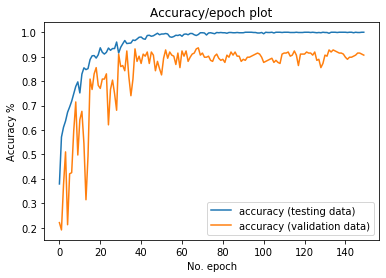

In [18]:
plt.plot(hist.history['accuracy'], label='accuracy (testing data)')
plt.plot(hist.history['val_accuracy'], label='accuracy (validation data)')
plt.title('Accuracy/epoch plot')
plt.ylabel('Accuracy %')
plt.xlabel('No. epoch')
plt.legend(loc="lower rigth")
plt.show()

In [19]:
nn.save_weights("first_iter150ep.h5")

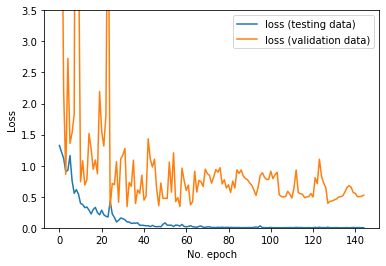

In [44]:
plt.plot(hist.history['loss'][5:], label='loss (testing data)')
plt.plot(hist.history['val_loss'][5:], label='loss (validation data)')
# plt.title(label[i] + " loss/epoch plot." + " Opt: {}".format(opt))
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.ylim((0,3.5))
plt.legend(loc="upper right")
plt.show()

In [47]:
import numpy as np
np.max(hist1.history['val_accuracy'])

0.9404255

In [34]:
import pickle
with open("hist_first150.pickle", "wb") as f:
    pickle.dump(hist.history, f)